## I have leraned how to use tflite for inference, now I want to try trainng from scrathch by CNN.

So far, we saw how to build a Dense Neural Network (DNN) that classified images of digits (MNIST) or even fashion images (Fashion-MNIST). Here we will instead, recognize the 10 classes of CIFAR ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship' and 'truck'). There are some key differences between these two image datasets that we need to take into account.

First, while MNIST were 28x28 monochrome images (1 color channel), CIFAR is 32x32 color images (3 color channels).

Second, MNIST images are simple, containing just the object centered in the image, with no background. Conversely, CIFAR ones are not centered and can have the object with a background, such as airplanes that might have a cloudy sky behind them! Those differences are the main reason to use a CNN instead of a DNN.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
cifar10 = tf.keras.datasets.cifar10
(train_imgs, train_labels), (test_imgs, test_labels) = cifar10.load_data()

In [3]:
print(train_imgs.shape, train_labels.shape)
print(test_imgs.shape, test_labels.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


### so we got images like 32 * 32 * 3, trying to see the images and labels

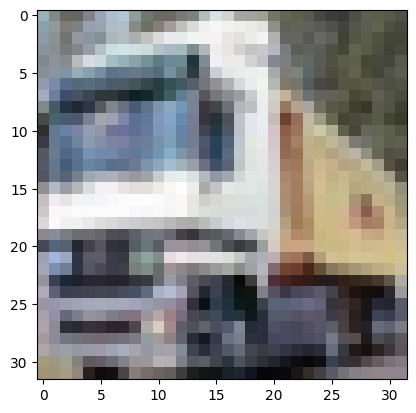

In [4]:
plt.imshow(train_imgs[1])

In [5]:
print(train_labels[1])

[9]


In [6]:
print(train_labels[1][0])

9


### The labels looks inside of a tensor, so need twice to collect the value.

remind that we have 10 labels, 0-9

In [7]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [8]:
class_names[train_labels[1][0]]

'truck'

### Infact lots of the images are 255 pixels, to avoid from gradient explosion, need to normalize it.

In [9]:
train_imgs.max()

np.uint8(255)

In [10]:
test_imgs.max()

np.uint8(255)

In [11]:
train_imgs = train_imgs / 255.0
test_imgs = test_imgs / 255.0

In [12]:
train_imgs.max()

np.float64(1.0)

In [13]:
test_imgs.max()

np.float64(1.0)

### Althouth this is a hight quality dataset, but we still need to check the distribution of labels to avoid from bias

(array([5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
        5000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

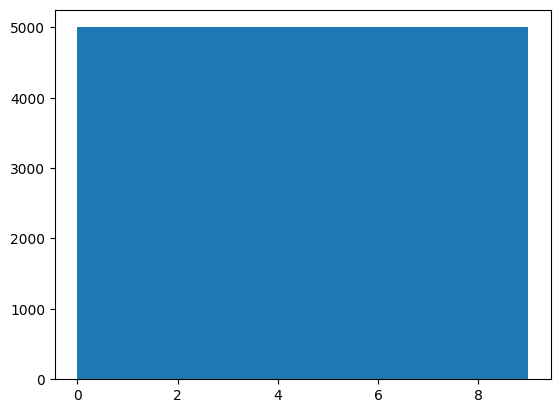

In [14]:
plt.hist(train_labels)

### Casue we want the accurate performance, we need the valid set and the new size train set.

In [15]:
validation_imgs = train_imgs[:5000]
validation_labels = train_labels[:5000]
print(validation_imgs.shape, validation_labels.shape)

(5000, 32, 32, 3) (5000, 1)


### The train size should be reset to 45000.

In [16]:
train_imgs = train_imgs[5000:]
train_labels = train_labels[5000:]
print(train_imgs.shape, train_labels.shape)

(45000, 32, 32, 3) (45000, 1)


Text(0.5, 1.0, 'Distribution of labels')

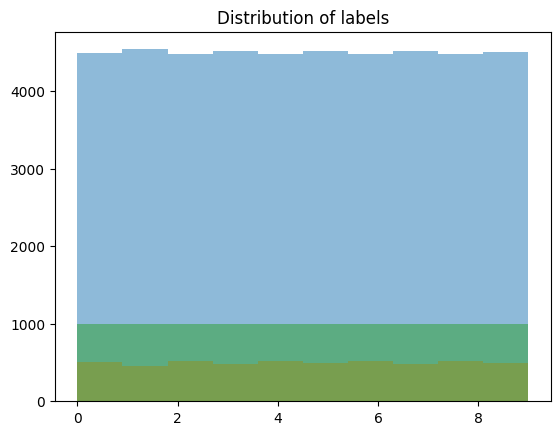

In [17]:
plt.hist(train_labels, alpha=0.5)
plt.hist(validation_labels, alpha=0.5)
plt.hist(test_labels, alpha=0.5)
plt.title("Distribution of labels")

### Create the model architecture and compile it

Remind the compile is set the loss function and optimizer.

On [Convolution layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D),
- strides is an integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width. Default (1,1).
- padding: one of "valid" or "same" (case-insensitive). Default = 'valid'.
  - "valid" means no padding.  
  - "same" results in padding with zeros evenly
to the left/right or up/down of the input such that output has the same


In [18]:
model = Sequential()

# First Conv Layer
model.add(Conv2D(
    filters=32,
    kernel_size=(3, 3),
    activation="relu",
    input_shape=(32, 32, 3)
))

model.add(MaxPool2D(pool_size=(2,2)))

# Seconnd Conv Layer
model.add(Conv2D(
    filters=64,
    kernel_size=(3,3),
    activation="relu"
))

model.add(MaxPool2D(pool_size=(2,2)))

# Going to output, but first need to flatten to feed into Full connnected Layer
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.summary()


c:\Users\prp\.virtualenvs\RA-BKpWPXUI\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,562 (654.54 KB)

 Trainable params: 167,562 (654.54 KB)

 Non-trainable params: 0 (0.00 B)

### However, the model have'n compiled yet, the keras uses both funtionnal call and Strings to define the methods. But we recommend functionnal call, which is close to pytorch.

In [19]:
# keras use String


LOSS = 'sparse_categorical_crossentropy'
OPTIMIZER = 'adam'

# Compile the model
model.compile(optimizer=OPTIMIZER,
              loss=LOSS,
              metrics=['accuracy'])

In [20]:
from tensorflow.keras import optimizers, losses

In [21]:
# keras use Functional call]


# Recommand 

model.compile(
    loss = losses.SparseCategoricalCrossentropy(),
    optimizer = optimizers.Adam(learning_rate=0.001),
    metrics = ["accuracy"]
)

## Now time to train the model

In [22]:
epoch = 20

early_stop = EarlyStopping(monitor="val_loss", patience=4)

In [23]:
# Traning

history = model.fit(
    train_imgs,
    train_labels,
    epochs=epoch,
    validation_data=(validation_imgs, validation_labels),
    #callbacks will store some addtional order to training process
    callbacks=[early_stop]
)

Epoch 1/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4650 - loss: 1.4839 - val_accuracy: 0.5408 - val_loss: 1.2907
Epoch 2/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5988 - loss: 1.1410 - val_accuracy: 0.6376 - val_loss: 1.0510
Epoch 3/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6475 - loss: 1.0081 - val_accuracy: 0.6578 - val_loss: 0.9886
Epoch 4/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6829 - loss: 0.9127 - val_accuracy: 0.6814 - val_loss: 0.9210
Epoch 5/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7109 - loss: 0.8319 - val_accuracy: 0.6750 - val_loss: 0.9370
Epoch 6/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7340 - loss: 0.7664 - val_accuracy: 0.7000 - val_loss: 0.9074
Epoch 7/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7570 - loss: 0.7055 - val_accuracy: 0.7094 - val_loss: 0.8651
Epoch 8/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7745 - loss: 0.6492 - 

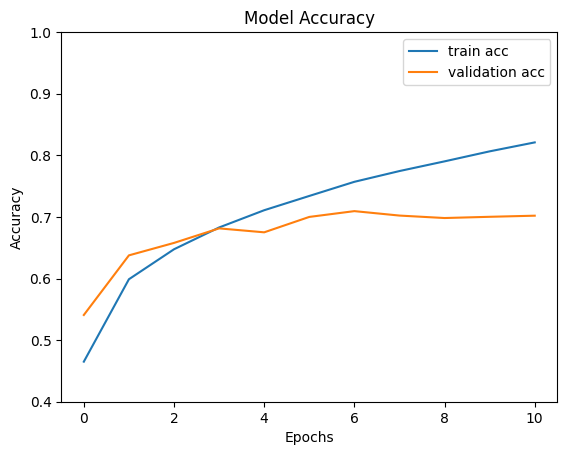

In [24]:
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="validation acc")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim([0.4,1.0])
plt.legend()

### The objective history has all the information during the training, which is a dictionary and covers all metrics we set both in compile and fit().

## What is the picture means ? In the training set, the accuracy is getting better but the validation set is getting worse, means the model is overfitting.

### Now we can use the evlauate function to see the performace. Remind it's `model.evaluate()`

In [25]:
model.evaluate(test_imgs, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6940 - loss: 0.9845


[0.9845355749130249, 0.6940000057220459]

In [26]:
predictions = model.predict(test_imgs)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [27]:
predictions.shape

(10000, 10)

### The prediction covers 10 classes, we need split the max value inside to get the predict.

In [28]:
# argmax for getting the max value index, which axis=1 measn from the column, axis-0 means from the row

predictions = np.argmax(predictions, axis=1)
predictions.shape

(10000,)

### To see how well the model is, we can not only use `evaluate()`, but also use `classification_report` and `confusion_matrix` from sklearn.

`classification_report` receives the true labels and predicted labels, and target_names is the class names, making a beautiful reoprt table.

`confusion_matrix` always cobines with `heatmap()` from seaborn to show the results.

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

In [30]:
print(classification_report(test_labels, predictions, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.75      0.74      0.74      1000
  automobile       0.81      0.82      0.81      1000
        bird       0.58      0.64      0.61      1000
         cat       0.52      0.48      0.50      1000
        deer       0.64      0.63      0.64      1000
         dog       0.60      0.55      0.57      1000
        frog       0.74      0.78      0.76      1000
       horse       0.75      0.71      0.73      1000
        ship       0.73      0.86      0.79      1000
       truck       0.82      0.73      0.77      1000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000



In [31]:
confusion_matrix(test_labels, predictions)

array([[736,  23,  64,  15,  18,   8,  12,   7, 100,  17],
       [ 28, 816,  13,   7,   5,   3,  13,   4,  42,  69],
       [ 49,   8, 638,  49,  81,  56,  66,  30,  19,   4],
       [ 27,   8,  77, 484,  72, 161,  81,  35,  39,  16],
       [ 24,   4,  92,  53, 632,  46,  51,  78,  17,   3],
       [ 16,   3,  87, 186,  48, 547,  30,  50,  21,  12],
       [  7,   5,  60,  50,  35,  23, 783,  10,  19,   8],
       [ 15,   6,  50,  54,  77,  55,  11, 710,  11,  11],
       [ 48,  31,  10,  12,   5,   4,   6,   4, 862,  18],
       [ 32, 103,  16,  18,   9,  11,  12,  17,  50, 732]])

In [32]:
import seaborn as sns

<Axes: >

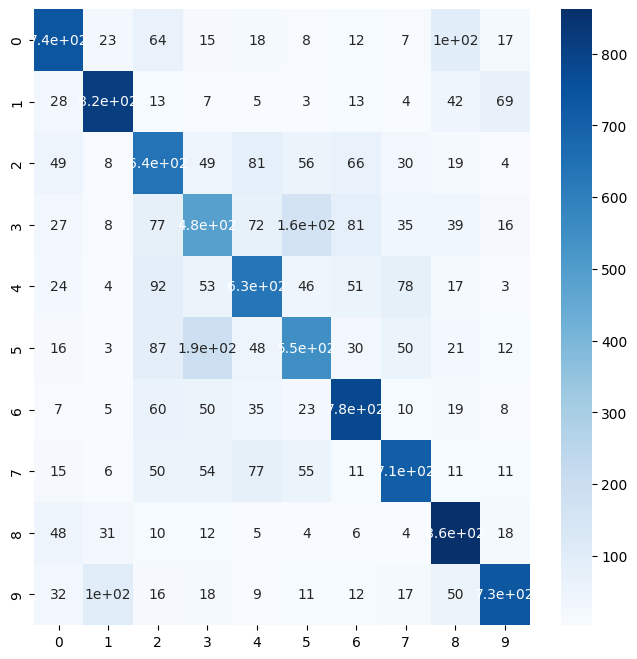

In [33]:
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(test_labels, predictions), cmap="Blues", annot=True)

### Time to see the ture images with the predictions

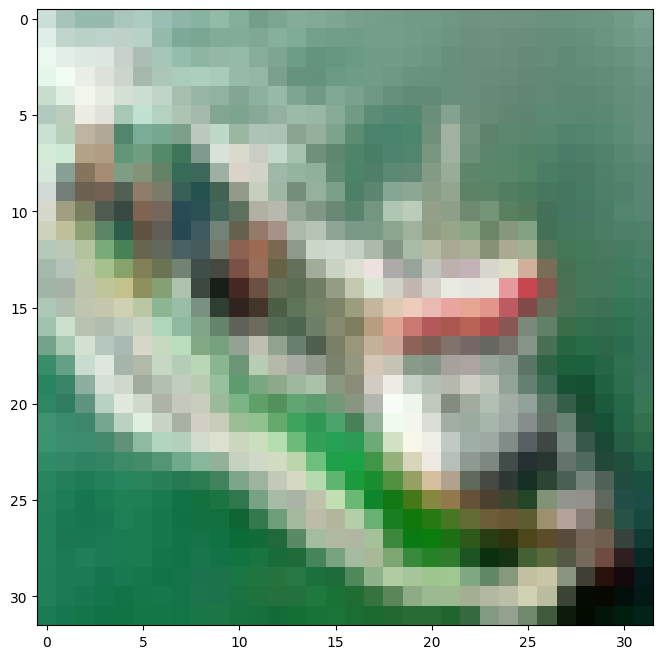

In [34]:
plt.figure(figsize=(8,8))
plt.imshow(test_imgs[15])

In [ ]:
test_labels[15][0]

np.uint8(8)

We get the true label here

In [38]:
true_label = class_names[test_labels[15][0]]
true_label

'ship'

In [40]:
inputs = test_imgs[15].reshape(1, 32, 32, 3)
inputs.shape

(1, 32, 32, 3)

In [42]:
label_pred = model.predict(inputs)
label_pred.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


(1, 10)

In [45]:
class_names[np.argmax(label_pred, axis=1)[0]]

'airplane'

### You see that, airplane, the wrongh prediction, anyway our model is only 70% accurate, so it's okay

In [50]:
def img_pred(img, size=4):
    label = test_labels[img][0]
    my_image = test_imgs[img]
    plt.figure(figsize=(size,size))
    plt.imshow(my_image)
    my_image = my_image.reshape(1,32,32,3)
    img_pred = np.argmax(model.predict(my_image))
    pred_label = class_names[img_pred]
    pred_prob = model.predict(my_image)[0][img_pred]
    print(" Label {} <=> Pred: {} with prob {:.2}".format(
        class_names[label],
        pred_label,
        pred_prob))
    plt.grid(False)
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
 Label cat <=> Pred: cat with prob 0.78


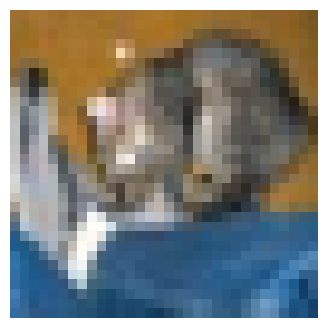

In [51]:
img_pred(0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
 Label ship <=> Pred: airplane with prob 0.46


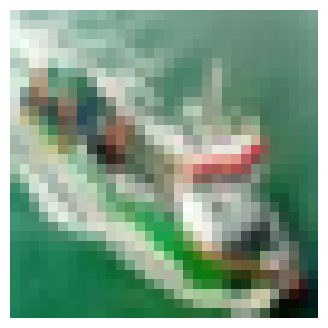

In [52]:
img_pred(15)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
 Label dog <=> Pred: dog with prob 0.84


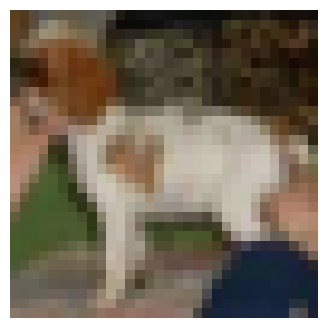

In [53]:
img_pred(12)

### Time to save what we got here

In [ ]:
# Please be noticed that now the model need to has ".keras" or ".h5" in the end
model.save("./cifar10_cnn_model.keras")

Can use [Netron](https://netron.app) to visualize the model

### Because in Raspberry Pi we using the TensorFlow Lite, we need to convert the model to .tflite  

Remind TensorFlow is not as smart as transformer, we need to load the model, then convert it.

In [65]:
model_path = "./cifar10_cnn_model.keras"
model = tf.keras.models.load_model(model_path)


converter = tf.lite.TFLiteConverter.from_keras_model(model=model)

In [66]:
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\prp\AppData\Local\Temp\tmpmzssjcw5\assets


INFO:tensorflow:Assets written to: C:\Users\prp\AppData\Local\Temp\tmpmzssjcw5\assets


Saved artifact at 'C:\Users\prp\AppData\Local\Temp\tmpmzssjcw5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  1713262156240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1713262157008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1713262156432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1713262154128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1713262157392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1713262157200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1713262153936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1713262158160: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [67]:
open("cifar10_cnn_model.tflite", "wb").write(tflite_model)

674340

### To reduce the model size, we can do quantization, which named optimization in TesorFlowLite

In [68]:
model = tf.keras.models.load_model("./cifar10_cnn_model.keras")
converter_quantized = tf.lite.TFLiteConverter.from_keras_model(model=model)

# The model will automatically do quantization, mostly do int8 quantization
converter_quantized.optimizations = [tf.lite.Optimize.DEFAULT]
tf_lite_quantized_model = converter_quantized.convert()

INFO:tensorflow:Assets written to: C:\Users\prp\AppData\Local\Temp\tmpihnztte9\assets


INFO:tensorflow:Assets written to: C:\Users\prp\AppData\Local\Temp\tmpihnztte9\assets


Saved artifact at 'C:\Users\prp\AppData\Local\Temp\tmpihnztte9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  1713225960720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1713225960912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1713225968784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1713225959760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1712489967888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1713225967824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1713225970512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1713262154320: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [70]:
open("tf_lite_quantized_model", "wb").write(tf_lite_quantized_model)

178160

### That's all about traning a model from tensorflow, and save it as the tflite, while we can make it been deployed in Raspberry Pi by getting the labels and tflite file